In [1]:
import pymc3 as pm
import arviz as az
import xarray as xr

from generate_data import generate_data

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
n = 70
Years_indiv, Mean_RT_comp_Indiv, Mean_RT_incomp_Indiv = generate_data(8, n)

dims = {"y_obs_comp": ["subject"], "y_obs_incomp": ["subject"]}

In [3]:
Mean_RT_comp_Indiv.shape

(70,)

In [4]:
with pm.Model() as model_pow:
    α_c = pm.HalfCauchy('α_c', 10)
    α_i = pm.HalfCauchy('α_i', 10)
    β = pm.Normal('β', 1, 2)
    γ_c = pm.Normal('γ_c', Mean_RT_comp_Indiv.mean(), .5)
    γ_i = pm.Normal('γ_i', Mean_RT_incomp_Indiv.mean(), .5)
    σ = pm.HalfNormal('σ', .2)
    μ_c = α_c*Years_indiv**-β + γ_c
    μ_i = α_i*Years_indiv**-β + γ_i
    y_obs_comp = pm.Normal('y_obs_comp', μ_c, σ, observed=Mean_RT_comp_Indiv)
    y_obs_incomp = pm.Normal('y_obs_incomp', μ_i, σ, observed=Mean_RT_incomp_Indiv)

    trace_pow = pm.sample(2000, chains=4, cores=4, tune=2000, target_accept=.9)
    idata_pow = az.from_pymc3(trace_pow, dims=dims)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  del sys.path[0]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, γ_i, γ_c, β, α_i, α_c]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 8 seconds.
There were 198 divergences after tuning. Increase `target_accept` or reparameterize.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
There were 205 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8066496046789537, but should be close to 0.9. Try to increase the number of tuning steps.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


0, dim: subject, 70 =? 0
0, dim: subject, 70 =? 0


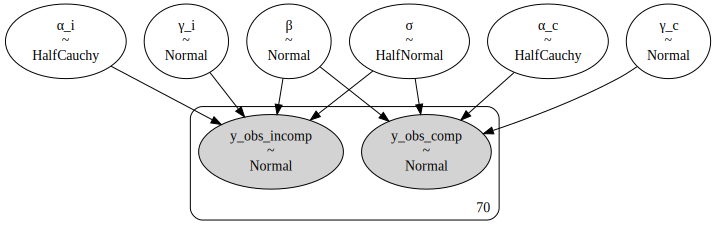

In [9]:
pm.model_to_graphviz(model_pow)

In [11]:
with pm.Model() as model_exp:
    α_c = pm.HalfCauchy('α_c', 5)
    α_i = pm.HalfCauchy('α_i', 5)
    β = pm.Normal('β', 1, 1)
    γ_c = pm.Normal('γ_c', Mean_RT_comp_Indiv.mean(), .5)
    γ_i = pm.Normal('γ_i', Mean_RT_incomp_Indiv.mean(), .5)
    σ = pm.HalfNormal('σ', .2)
    μ_c = α_c*pm.math.exp(-β*Years_indiv) + γ_c
    μ_i = α_i*pm.math.exp(-β*Years_indiv) + γ_i
    y_obs_comp = pm.Normal('y_obs_comp', μ_c, σ, observed=Mean_RT_comp_Indiv)
    y_obs_incomp = pm.Normal('y_obs_incomp', μ_i, σ, observed=Mean_RT_incomp_Indiv)

    trace_exp = pm.sample(2000, chains=4, cores=4, tune=2000, target_accept=.9)
    idata_exp = az.from_pymc3(trace_exp, dims=dims)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  del sys.path[0]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, γ_i, γ_c, β, α_i, α_c]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.


0, dim: subject, 70 =? 0
0, dim: subject, 70 =? 0


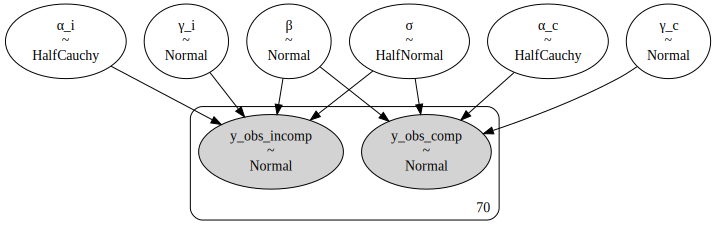

In [12]:
pm.model_to_graphviz(model_exp)

The pointwise log likelihood stored is the following (both models have the same variables and shape, only the exponential model is shown)

In [13]:
idata_exp.log_likelihood

<xarray.Dataset>
Dimensions:       (chain: 4, draw: 2000, subject: 70)
Coordinates:
  * chain         (chain) int64 0 1 2 3
  * draw          (draw) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * subject       (subject) int64 0 1 2 3 4 5 6 7 8 ... 62 63 64 65 66 67 68 69
Data variables:
    y_obs_comp    (chain, draw, subject) float64 -1.367 -1.921 ... -0.9427
    y_obs_incomp  (chain, draw, subject) float64 -1.372 -1.285 ... -1.266 -1.075
Attributes:
    created_at:                 2021-07-03T02:21:35.905164
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.2

IC calculation and model comparison starts here

In [14]:
log_lik_exp = idata_exp.log_likelihood
log_lik_pow = idata_pow.log_likelihood

In [24]:
print("Leave one *observation* out cross validation (whole model)\n")
condition_dim = xr.DataArray(["compatible", "incompatible"], name="condition")
idata_exp.sample_stats["log_likelihood"] = xr.concat((log_lik_exp.y_obs_comp, log_lik_exp.y_obs_incomp), dim=condition_dim)
idata_pow.sample_stats["log_likelihood"] = xr.concat((log_lik_pow.y_obs_comp, log_lik_pow.y_obs_incomp), dim=condition_dim)
print(az.loo(idata_exp))
az.compare({"exp": idata_exp, "pow": idata_pow})

Leave one *observation* out cross validation (whole model)

Computed from 8000 by 140 log-likelihood matrix

         Estimate       SE
elpd_loo  -199.71     8.52
p_loo        3.50        -


/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
exp,0,-199.706475,3.500951,0.000000,1.0,8.519694,0.000000,False,log
pow,1,-200.039294,3.758542,0.332819,0.0,8.469096,0.315339,False,log


In [20]:
idata_exp

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [25]:
idata_exp.sample_stats["log_likelihood"].shape

(2, 4, 2000, 70)

In [26]:
print("Leave one *subject* out cross validation (whole model)\n")
idata_exp.sample_stats["log_likelihood"] = log_lik_exp.y_obs_comp + log_lik_exp.y_obs_incomp
idata_pow.sample_stats["log_likelihood"] = log_lik_pow.y_obs_comp + log_lik_pow.y_obs_incomp
print(az.loo(idata_exp))
az.compare({"exp": idata_exp, "pow": idata_pow})

Leave one *subject* out cross validation (whole model)

Computed from 8000 by 70 log-likelihood matrix

         Estimate       SE
elpd_loo  -199.68     8.10
p_loo        3.44        -


/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
exp,0,-199.676204,3.438324,0.000000,1.0,8.102254,0.000000,False,log
pow,1,-200.004835,3.693650,0.328631,0.0,8.031175,0.338736,False,log


In [27]:
idata_exp

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [28]:
idata_exp.sample_stats["log_likelihood"].shape

(4, 2000, 70)

In [9]:
print("Leave one observation out cross validation (y_obs_comp only)\n")
idata_exp.sample_stats["log_likelihood"] = log_lik_exp.y_obs_comp
idata_pow.sample_stats["log_likelihood"] = log_lik_pow.y_obs_comp
print(az.loo(idata_exp))
az.compare({"exp": idata_exp, "pow": idata_pow})

Leave one observation out cross validation (y_obs_comp only)

Computed from 8000 by 70 log-likelihood matrix

         Estimate       SE
elpd_loo   -98.28     7.61
p_loo        1.96        -


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
exp,0,-98.2835,1.9639,0,0.588863,7.56799,0,False,log
pow,1,-98.642,2.20069,0.358573,0.411137,7.55913,0.095881,False,log


In [10]:
print("Leave one observation out cross validation (y_obs_incomp only)\n")
idata_exp.sample_stats["log_likelihood"] = log_lik_exp.y_obs_incomp
idata_pow.sample_stats["log_likelihood"] = log_lik_pow.y_obs_incomp
print(az.loo(idata_exp), "\n")
az.compare({"exp": idata_exp, "pow": idata_pow})

Leave one observation out cross validation (y_obs_incomp only)

Computed from 8000 by 70 log-likelihood matrix

         Estimate       SE
elpd_loo  -102.98     5.93
p_loo        1.77        - 



,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
exp,0,-102.978,1.77499,0,0.527871,5.94768,0,False,log
pow,1,-103.083,1.87895,0.105294,0.472129,5.92998,0.180884,False,log
